In [3]:
%pip install -q ultralytics PyYAML


Note: you may need to restart the kernel to use updated packages.


In [5]:
import datetime
import shutil
from pathlib import Path
from collections import Counter

import yaml
import numpy as np
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import KFold
import glob, os
from PIL import Image

In [5]:
import os
import shutil
import glob

TARGET_IMAGES_PATH = 'yolo_kfold/images/'
TARGET_LABELS_PATH = 'yolo_kfold/labels/'

source_folder_path = r"E:\vrinda\classification\classification\yolo_kfold\dataapril18\{split}\{type}"
splits = ["train", "valid"]
types = ["images/*.jpg", "labels/*.txt"]

os.makedirs(TARGET_IMAGES_PATH, exist_ok=True)
os.makedirs(TARGET_LABELS_PATH, exist_ok=True)

image_paths = []
label_paths = []

for split in splits:
    for data_type in types:
        files = glob.glob(source_folder_path.format(split=split, type=data_type))
        for file_ in files:
            if "image" in data_type:
                shutil.copy(file_, TARGET_IMAGES_PATH)
            else:
                shutil.copy(file_, TARGET_LABELS_PATH)

# Store image and label paths for future use
image_paths = glob.glob(TARGET_IMAGES_PATH + "*.jpg")
label_paths = glob.glob(TARGET_LABELS_PATH + "*.txt")


In [6]:
image_paths

['yolo_kfold/images\\00060fe2-f996-4fe8-8f69-5573f18154f0_png.rf.3cad49b35ae9a8387662fb6df27a01c8.jpg',
 'yolo_kfold/images\\00060fe2-f996-4fe8-8f69-5573f18154f0_png.rf.45e5de60272fba4820abc04663c8b5c5.jpg',
 'yolo_kfold/images\\0012e899-c88e-4250-aae1-7112e089e1c0-background_removed_png.rf.1e30e40e46b0a52f3fbcf04293b98671.jpg',
 'yolo_kfold/images\\0012e899-c88e-4250-aae1-7112e089e1c0-background_removed_png.rf.becca6a2da1cb63b268db0d58bb2c369.jpg',
 'yolo_kfold/images\\00238dd4-6ff5-444d-bbc6-5500dc967579-background_removed_png.rf.1549b716d06e018b3fdffd849c853fd6.jpg',
 'yolo_kfold/images\\00238dd4-6ff5-444d-bbc6-5500dc967579-background_removed_png.rf.2318f4a264beecf34e2ea8020255341e.jpg',
 'yolo_kfold/images\\0052a5a8-c863-4547-b937-18edcf8ade17_png.rf.24b4a33bdeddefadf2c7c365f30713f9.jpg',
 'yolo_kfold/images\\0052a5a8-c863-4547-b937-18edcf8ade17_png.rf.f7b8934c1e6aca2693b0a9acd4bbda89.jpg',
 'yolo_kfold/images\\00b6af5733d9469ab9f9eccfc0756da2_jpg.rf.68011a39e71a4dc8dfbc3c56a04291b

In [7]:
dataset_path = Path(r'E:\vrinda\classification\classification\yolo_kfold\yolo_kfold') # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*labels\*.txt")) # all data in 'labels'

yaml_file = r'E:\vrinda\classification\classification\yolo_kfold\dataapril18\data.yaml'  # your data YAML with data directories and names dictionary
with open(yaml_file, 'r', encoding="utf8") as y:
    classes = yaml.safe_load(y)['names']
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('alcohol-bottle', 0), ('wine-glass', 1)]


In [8]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [9]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df

C:\Users\KUDSIT\AppData\Local\Temp\ipykernel_7212\3131205890.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


,0,1
00060fe2-f996-4fe8-8f69-5573f18154f0_png.rf.3cad49b35ae9a8387662fb6df27a01c8,1.0,0.0
00060fe2-f996-4fe8-8f69-5573f18154f0_png.rf.45e5de60272fba4820abc04663c8b5c5,3.0,0.0
0012e899-c88e-4250-aae1-7112e089e1c0-background_removed_png.rf.1e30e40e46b0a52f3fbcf04293b98671,1.0,0.0
0012e899-c88e-4250-aae1-7112e089e1c0-background_removed_png.rf.becca6a2da1cb63b268db0d58bb2c369,5.0,0.0
00238dd4-6ff5-444d-bbc6-5500dc967579-background_removed_png.rf.1549b716d06e018b3fdffd849c853fd6,5.0,0.0
...,...,...
gin_cam5_jpg.rf.e028a60f479dafe6691622455fea189e,1.0,0.0
gin_cam7_jpg.rf.498c876886fd3ee08952f8e2302fbe47,4.0,0.0
gin_cam7_jpg.rf.7f56879042782654c4b75ec673f0a062,1.0,0.0
gin_cao3_jpg.rf.05b142ebd6f9df156ef6a85cfd47d29a,1.0,0.0


In [10]:
labels_df.shape

(4899, 2)

In [11]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [12]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

In [13]:
fold_lbl_distrb


,0,1
split_1,0.52156,0.500735
split_2,0.482654,0.550912
split_3,0.496304,0.451636


In [14]:
kfold_base_path = Path('detection/kfold')
shutil.rmtree(kfold_base_path) if kfold_base_path.is_dir() else None # Remove existing folder
os.makedirs(str(kfold_base_path)) # Create nww folder
yaml_paths = list()
train_txt_paths = list()
val_txt_paths = list()
for i, (train_idx, val_idx) in enumerate(kfolds):
    # Get image paths for train-val split
    train_paths = [image_paths[j] for j in train_idx]
    val_paths = [image_paths[j] for j in val_idx]
    # Create text files to store image paths
    train_txt = kfold_base_path / f"train_{i}.txt"
    val_txt =  kfold_base_path / f"val_{i}.txt"

    # Write images paths for training and validation in split i
    with open(str(train_txt), 'w') as f:
        f.writelines(s + '\n' for s in train_paths)
    with open(str(val_txt), 'w') as f:
        f.writelines(s + '\n' for s in val_paths)

    train_txt_paths.append(str(train_txt))
    val_txt_paths.append(str(val_txt))

    # Create yaml file
    yaml_path = kfold_base_path / f'data_{i}.yaml'
    with open(yaml_path, 'w') as ds_y:
        yaml.safe_dump({
            'train': str(train_txt.name),
            'val': str(val_txt.name),
            'names': classes
        }, ds_y)
    yaml_paths.append(str(yaml_path))
print("Yaml Paths")
print(yaml_paths)

Yaml Paths
['detection\\kfold\\data_0.yaml', 'detection\\kfold\\data_1.yaml', 'detection\\kfold\\data_2.yaml']


In [15]:
yaml_paths[0]

'detection\\kfold\\data_0.yaml'

In [16]:
dataset_yaml = r"E:\vrinda\classification\classification\yolo_kfold\\" + yaml_paths[0]


In [17]:
from IPython.display import clear_output
import time
os.environ['WANDB_DISABLED'] = 'true'

batch = 16
project = 'runs'
epochs = 100

results = list()

for i in range(ksplit):
    model = YOLO('yolov8s.pt')
    dataset_yaml = r"E:\vrinda\classification\classification\yolo_kfold\\" + yaml_paths[i]
    print(f"Training for fold={i} using {dataset_yaml}")
    model.train(data=dataset_yaml, batch=batch, project=project, epochs=epochs, verbose=True, workers=28)
    result = model.metrics # Metrics on validation set
    results.append(result) # save output metrics for further analysis
    clear_output()


In [2]:
metric_values = dict()

for result in results:
    for metric, metric_val in result.results_dict.items():
        if metric not in metric_values:
            metric_values[metric] = []
        metric_values[metric].append(metric_val)

metric_df = pd.DataFrame.from_dict(metric_values)
visualize_metric = ['mean', 'std', 'min', 'max']
metric_df.describe().loc[visualize_metric]

NameError: name 'results' is not defined

In [21]:
image_paths[4]

'yolo_kfold/images\\00238dd4-6ff5-444d-bbc6-5500dc967579-background_removed_png.rf.1549b716d06e018b3fdffd849c853fd6.jpg'


image 1/1 e:\vrinda\classification\classification\yolo_kfold\yolo_kfold\images\00238dd4-6ff5-444d-bbc6-5500dc967579-background_removed_png.rf.1549b716d06e018b3fdffd849c853fd6.jpg: 640x640 5 alcohol-bottles, 71.8ms
Speed: 5.0ms preprocess, 71.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


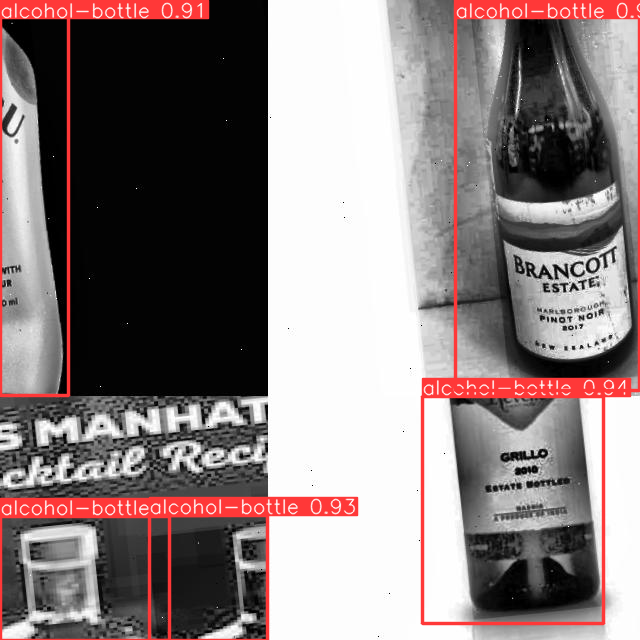

In [19]:
pred = model(image_paths[4])
img_arr = pred[0].plot()
im = Image.fromarray(img_arr[..., ::-1])  # RGB PIL image
im  # show image


image 1/1 E:\vrinda\classification\classification\yolo_april_17\unnamed.png: 608x640 1 alcohol-bottle, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs\detect\predict8


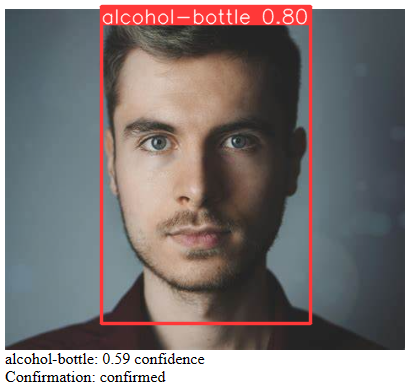

In [12]:
from ultralytics import YOLO

model = YOLO(r"E:\vrinda\classification\classification\yolo_kfold\runs\train\weights\best.pt")
pred =model.predict(source=r"E:\vrinda\classification\classification\yolo_april_17\unnamed.png",save=True,visualize=False) # Display preds. Accepts all YOLO predict arguments
img_arr = pred[0].plot()
im = Image.fromarray(img_arr[..., ::-1])  # RGB PIL image
im  # show image
